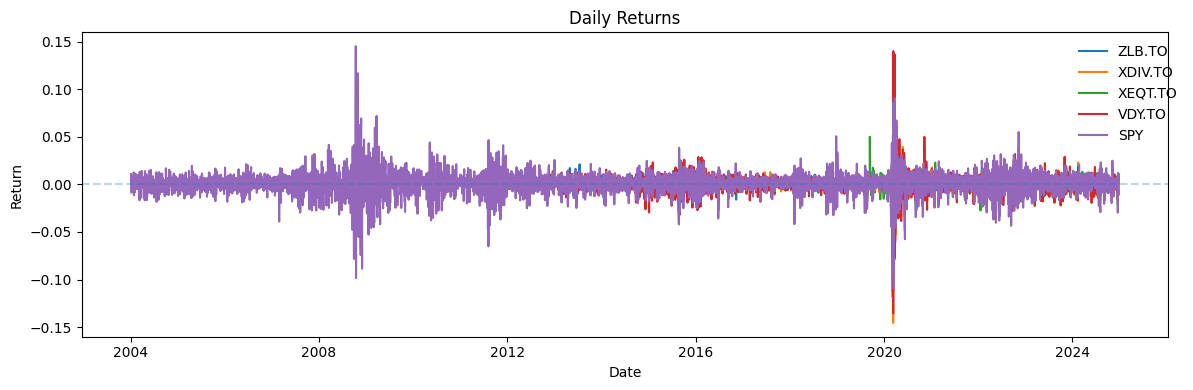

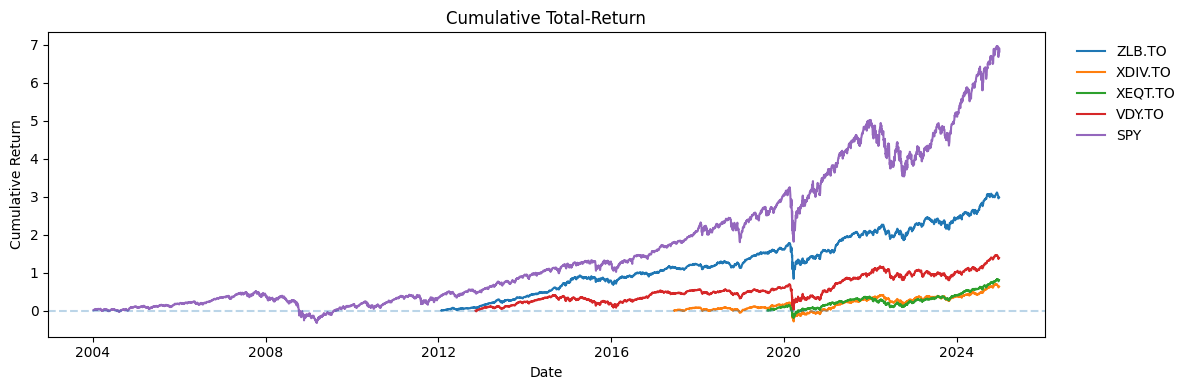

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import jarque_bera
import matplotlib.pyplot as plt

benchmark      = "SPY"
tickers_to_plot = ["ZLB.TO", "XDIV.TO", "XEQT.TO", "VDY.TO",benchmark]
start_date     = "2004-01-01"
end_date       = "2024-12-29"

price_df = yf.download(
    tickers_to_plot + [benchmark],
    start       = start_date,
    end         = end_date,
    auto_adjust = True,
    progress    = False
)["Close"]

# drop any tickers with no data
price_df = price_df.dropna(axis=1, how="all")

# Plot daily returns
plt.figure(figsize=(12, 4))
for tk in tickers_to_plot:
    if tk not in price_df.columns:
        continue
    r = price_df[tk].pct_change(fill_method=None).dropna()
    plt.plot(r.index, r.values, label=tk)
plt.axhline(0, linestyle="--", alpha=0.3)
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend(frameon=False, bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

# Plot cumulative total-return
plt.figure(figsize=(12, 4))
for tk in tickers_to_plot:
    if tk not in price_df.columns:
        continue
    r   = price_df[tk].pct_change(fill_method=None).dropna()
    cum = (1 + r).cumprod() - 1
    plt.plot(cum.index, cum.values, label=tk)
plt.axhline(0, linestyle="--", alpha=0.3)
plt.title("Cumulative Total-Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(frameon=False, bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()


Risk-Adjusted Metrics for ETFs:
         Sharpe  Sortino  Treynor  JensenAlpha  InfoRatio  MaxDrawdown  \
ZLB.TO    0.910    1.033    0.013        0.002     -0.316       -0.340   
XDIV.TO   0.425    0.460    0.007       -0.001     -0.539       -0.413   
XEQT.TO   0.581    0.711    0.008       -0.002     -0.827       -0.297   
VDY.TO    0.470    0.542    0.007       -0.002     -0.590       -0.395   

         Calmar  Omega  JB_pvalue   Skew  Kurtosis  RollingBetaStd  
ZLB.TO    0.021  1.226      0.000 -1.414    47.649           0.143  
XDIV.TO   0.013  1.117      0.000 -0.979    58.497           0.172  
XEQT.TO   0.022  1.132      0.000 -0.601    14.105           0.081  
VDY.TO    0.013  1.118      0.000 -0.363    52.134           0.180  

Interpretations:

=== ZLB.TO ===
• Returns deviate from normality (JB p < 0.05). Prefer Sortino, Calmar or Omega over Sharpe.
• Beta is stable. Treynor and Jensen’s α are reliable.
• Sortino and Sharpe within 20%. No extreme upside skew.

=== XDIV.TO 

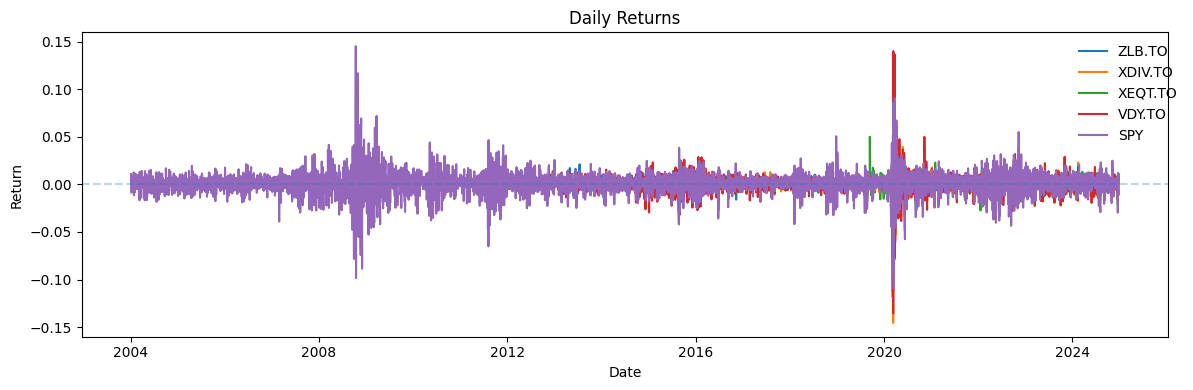

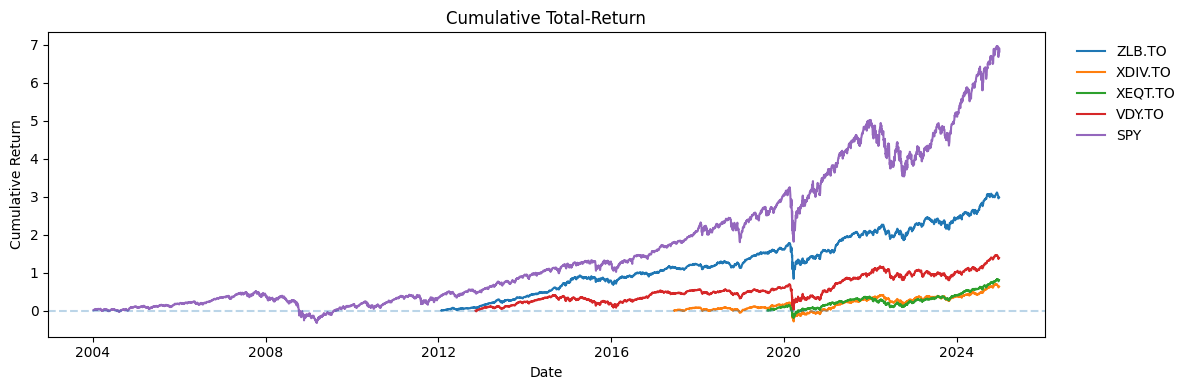

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import jarque_bera
import matplotlib.pyplot as plt

# 1. Define ETF tickers and benchmark
etf_tickers    = ["ZLB.TO", "XDIV.TO", "XEQT.TO", "VDY.TO"]
benchmark      = "SPY"
plot_list      = etf_tickers + [benchmark]
start_date     = "2004-01-01"
end_date       = "2024-12-29"

# 2. Download total-return series
price_df = yf.download(
    plot_list,
    start        = start_date,
    end          = end_date,
    auto_adjust  = True,
    progress     = False
)["Close"]

# 3. Compute risk metrics function
def compute_risk_metrics(asset_prices, bench_prices, risk_free_rate=0.01):
    r_a = asset_prices.pct_change().dropna()
    r_b = bench_prices.pct_change().dropna()
    df  = pd.concat([r_a, r_b], axis=1).dropna()
    df.columns = ["asset", "bench"]

    rf_daily = risk_free_rate / 252
    excess   = df["asset"] - rf_daily
    ann      = np.sqrt(252)

    sharpe     = ann * excess.mean() / excess.std()
    down       = excess[excess < 0]
    sortino    = ann * excess.mean() / down.std() if not down.empty else np.nan

    cov_ab     = np.cov(df["asset"], df["bench"])[0, 1]
    beta       = cov_ab / df["bench"].var()
    treynor    = ann * (df["asset"].mean() - rf_daily) / beta

    rm_rf      = df["bench"] - rf_daily
    jensen     = ann * (df["asset"].mean() - (rf_daily + beta * rm_rf.mean()))

    active     = df["asset"] - df["bench"]
    info_ratio = ann * active.mean() / active.std()

    cumret     = (1 + df["asset"]).cumprod()
    drawdown   = cumret.div(cumret.cummax()) - 1
    maxdd      = drawdown.min()
    calmar     = ann * df["asset"].mean() / abs(maxdd)

    gains      = df["asset"][df["asset"] >= 0].sum()
    losses     = -df["asset"][df["asset"] < 0].sum()
    omega      = gains / losses if losses != 0 else np.nan

    jb_stat, jb_p = jarque_bera(df["asset"])
    skew         = df["asset"].skew()
    kurtosis     = df["asset"].kurtosis()

    roll_cov     = df["asset"].rolling(60).cov(df["bench"])
    roll_var     = df["bench"].rolling(60).var()
    rbeta        = roll_cov.div(roll_var)

    return pd.Series({
        "Sharpe":         sharpe,
        "Sortino":        sortino,
        "Treynor":        treynor,
        "JensenAlpha":    jensen,
        "InfoRatio":      info_ratio,
        "MaxDrawdown":    maxdd,
        "Calmar":         calmar,
        "Omega":          omega,
        "JB_pvalue":      jb_p,
        "Skew":           skew,
        "Kurtosis":       kurtosis,
        "RollingBetaStd": rbeta.std()
    })

# 4. Build metrics DataFrame for ETFs (exclude SPY)
rows = []
for tk in etf_tickers:
    if tk not in price_df.columns:
        continue
    s_a = price_df[tk].dropna()
    s_b = price_df[benchmark].reindex(s_a.index).dropna()
    if len(s_a) < 252:
        continue
    metrics = compute_risk_metrics(s_a, s_b)
    metrics.name = tk
    rows.append(metrics)

metrics_df = pd.DataFrame(rows)
pd.set_option("display.float_format", "{:.3f}".format)

# 5. Print metrics table
print("Risk-Adjusted Metrics for ETFs:")
print(metrics_df)

# 6. Interpretation based on assumption checks
jb_thresh       = 0.05
beta_std_thresh = metrics_df['RollingBetaStd'].quantile(0.75)
upside_ratio    = metrics_df['Sortino'] / metrics_df['Sharpe']

print("\nInterpretations:")
for ticker, row in metrics_df.iterrows():
    print(f"\n=== {ticker} ===")
    if row['JB_pvalue'] < jb_thresh:
        print("• Returns deviate from normality (JB p < 0.05). Prefer Sortino, Calmar or Omega over Sharpe.")
    else:
        print("• Normality holds (JB p ≥ 0.05). Sharpe ratio is reliable.")
    if row['RollingBetaStd'] > beta_std_thresh:
        print("• Beta is unstable (high RollingBetaStd). Treynor and Jensen’s α may be unreliable.")
    else:
        print("• Beta is stable. Treynor and Jensen’s α are reliable.")
    if upside_ratio[ticker] > 1.2:
        print("• Sortino > 1.2× Sharpe indicates strong upside volatility. Emphasize downside-focused metrics.")
    else:
        print("• Sortino and Sharpe within 20%. No extreme upside skew.")

# 7. Plot daily returns and cumulative returns including SPY
# Plot daily returns
plt.figure(figsize=(12, 4))
for tk in plot_list:
    if tk in price_df.columns:
        r   = price_df[tk].pct_change(fill_method=None).dropna()
        plt.plot(r.index, r.values, label=tk)
plt.axhline(0, linestyle="--", alpha=0.3)
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend(frameon=False, bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

# Plot cumulative total-return
plt.figure(figsize=(12, 4))
for tk in plot_list:
    if tk in price_df.columns:
        r   = price_df[tk].pct_change(fill_method=None).dropna()
        cum = (1 + r).cumprod() - 1
        plt.plot(cum.index, cum.values, label=tk)
plt.axhline(0, linestyle="--", alpha=0.3)
plt.title("Cumulative Total-Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(frameon=False, bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()


In [9]:
import yfinance as yf
import pandas as pd

# Define the ETFs and date range
tickers = ["ZLB.TO", "XDIV.TO", "XEQT.TO", "VDY.TO","SPY"]
start_date = "2004-01-01"
end_date = "2024-12-29"

# Download auto-adjusted close prices
price_df = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)["Close"]

# Calculate annualized compounded returns
data = []
for tk in tickers:
    series = price_df[tk].dropna()
    if series.empty:
        continue
    first_price = series.iloc[0]
    last_price = series.iloc[-1]
    years = (series.index[-1] - series.index[0]).days / 365.25
    annualized_return = (last_price / first_price) ** (1 / years) - 1
    data.append({
        "Ticker": tk,
        "Start Date": series.index[0].date(),
        "End Date": series.index[-1].date(),
        "Years": round(years, 2),
        "Annualized Return (%)": round(annualized_return * 100, 2)
    })

annualized_df = pd.DataFrame(data).set_index("Ticker")

In [10]:
annualized_df

,Start Date,End Date,Years,Annualized Return (%)
Ticker,,,,
ZLB.TO,2012-01-24,2024-12-27,12.930,11.860
XDIV.TO,2017-06-15,2024-12-27,7.530,7.640
XEQT.TO,2019-08-14,2024-12-27,5.370,12.370
VDY.TO,2012-11-08,2024-12-27,12.130,8.130
SPY,2004-01-02,2024-12-27,20.990,10.380


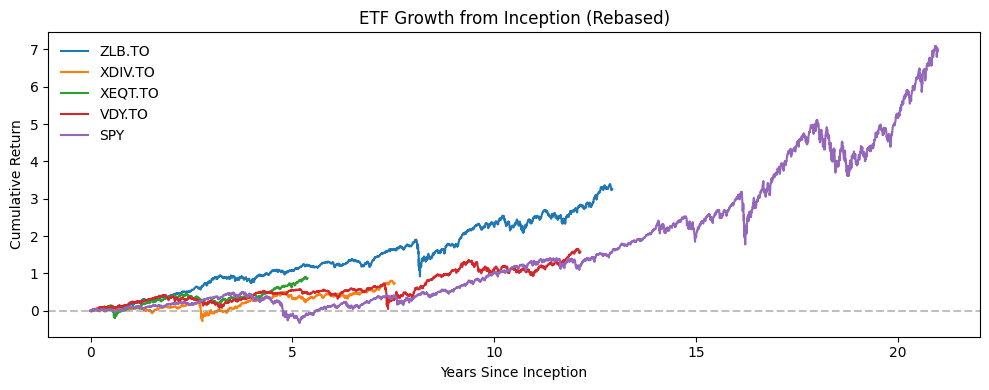

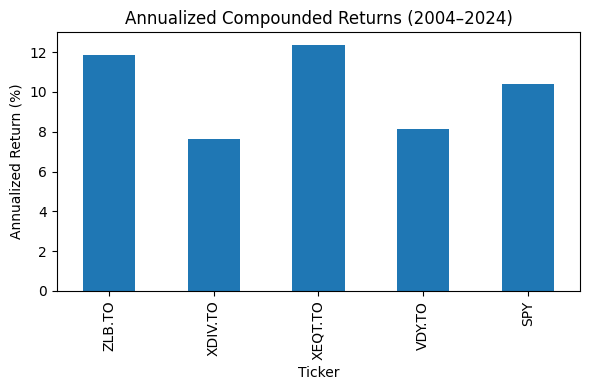

In [12]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

etfs       = ["ZLB.TO","XDIV.TO","XEQT.TO","VDY.TO","SPY"]
start, end = "2004-01-01","2024-12-29"

# 1) fetch and rebase
prices = yf.download(etfs, start=start, end=end, auto_adjust=True, progress=False)["Close"]
plt.figure(figsize=(10,4))
for tk in etfs:
    s = prices[tk].dropna()
    # compute time since inception in years
    years = (s.index - s.index[0]).days / 365.25
    rebased = s / s.iloc[0] - 1
    plt.plot(years, rebased, label=tk)
plt.axhline(0, color="gray", linestyle="--", alpha=0.5)
plt.xlabel("Years Since Inception")
plt.ylabel("Cumulative Return")
plt.title("ETF Growth from Inception (Rebased)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# 2) bar chart of annualized returns
data = []
for tk in etfs:
    s = prices[tk].dropna()
    yrs = (s.index[-1] - s.index[0]).days / 365.25
    ann = (s.iloc[-1] / s.iloc[0])**(1/yrs) - 1
    data.append((tk, ann*100))
df = pd.DataFrame(data, columns=["Ticker","AnnReturn"]).set_index("Ticker")

plt.figure(figsize=(6,4))
df["AnnReturn"].plot(kind="bar")
plt.ylabel("Annualized Return (%)")
plt.title("Annualized Compounded Returns (2004–2024)")
plt.tight_layout()
plt.show()
